In [24]:
import pandas as pd
import numpy as np
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from feature_engine.imputation import (
    CategoricalImputer,
)

from feature_engine.transformation import (
    YeoJohnsonTransformer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
    OneHotEncoder,
    CountFrequencyEncoder
)

import joblib

import matplotlib.pyplot as plt
import seaborn as sns

## Read Data

In [2]:
data = pd.read_csv('../src/data/train.csv')
print(data.shape)
data.head()

(19158, 14)


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


## Train-Test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['enrollee_id', 'target'], axis=1),
    data['target'],
    test_size=0.2,
    random_state=0,
)

## Missing Values

### Categorical Varibles

In [4]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']
cat_vars_with_na = [var for var in cat_vars if X_train[var].isnull().sum() > 0]

In [5]:
cat_vars

['city',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [6]:
data[cat_vars_with_na].isnull().mean().sort_values(ascending=False)

company_type           0.320493
company_size           0.309949
gender                 0.235306
major_discipline       0.146832
education_level        0.024011
last_new_job           0.022080
enrolled_university    0.020148
experience             0.003393
dtype: float64

In [7]:
cat_vars_replace_na_with_string_missing = [var for var in cat_vars_with_na if X_train[var].isnull().mean() > 0.1]
cat_vars_replace_na_with_frequent = [var for var in cat_vars_with_na if X_train[var].isnull().mean() <= 0.1]

In [8]:
cat_vars_replace_na_with_string_missing

['gender', 'major_discipline', 'company_size', 'company_type']

In [9]:
cat_vars_replace_na_with_frequent

['enrolled_university', 'education_level', 'experience', 'last_new_job']

In [10]:
cat_imputer_missing = CategoricalImputer(imputation_method='missing', variables=cat_vars_replace_na_with_string_missing)
cat_imputer_missing.fit(X_train)
cat_imputer_missing.imputer_dict_

{'gender': 'Missing',
 'major_discipline': 'Missing',
 'company_size': 'Missing',
 'company_type': 'Missing'}

In [11]:
X_train = cat_imputer_missing.transform(X_train)
X_test = cat_imputer_missing.transform(X_test)

In [12]:
cat_imputer_frequent = CategoricalImputer(imputation_method='frequent', variables=cat_vars_replace_na_with_frequent)
cat_imputer_frequent.fit(X_train)
cat_imputer_frequent.imputer_dict_

{'enrolled_university': 'no_enrollment',
 'education_level': 'Graduate',
 'experience': '>20',
 'last_new_job': '1'}

In [13]:
X_train = cat_imputer_frequent.transform(X_train)
X_test = cat_imputer_frequent.transform(X_test)

In [14]:
X_train[cat_vars_with_na].isnull().sum()

gender                 0
enrolled_university    0
education_level        0
major_discipline       0
experience             0
company_size           0
company_type           0
last_new_job           0
dtype: int64

In [15]:
X_test[cat_vars_with_na].isnull().sum()

gender                 0
enrolled_university    0
education_level        0
major_discipline       0
experience             0
company_size           0
company_type           0
last_new_job           0
dtype: int64

### Numerical Variables

In [16]:
num_vars = [var for var in data.columns if var not in cat_vars + ['enrollee_id', 'target']]
num_vars_with_na = [var for var in num_vars if X_train[var].isnull().sum() > 0]

In [17]:
num_vars

['city_development_index', 'training_hours']

In [18]:
num_vars_with_na

[]

## Transformations

### Numerical Variables

In [19]:
num_vars_yeo_johnson = ['training_hours']

yeo_transformer = YeoJohnsonTransformer(variables=num_vars_yeo_johnson)

X_train = yeo_transformer.fit_transform(X_train)
X_test = yeo_transformer.transform(X_test)

yeo_transformer.lambda_dict_

{'training_hours': 0.14533500139326166}

### Categorical Variables

In [20]:
X_train[cat_vars].head()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
19147,city_21,Male,No relevent experience,Full time course,Graduate,STEM,1,100-500,Pvt Ltd,1
8464,city_21,Missing,Has relevent experience,Full time course,Graduate,STEM,<1,<10,Pvt Ltd,1
8869,city_16,Male,Has relevent experience,no_enrollment,Masters,STEM,9,Missing,Pvt Ltd,1
11645,city_118,Missing,Has relevent experience,Part time course,Masters,STEM,10,1000-4999,Pvt Ltd,3
7743,city_103,Missing,No relevent experience,no_enrollment,Primary School,Missing,2,Missing,Missing,never


In [21]:
experience_map = {
    '<1': 0,
    '1': 1, 
    '2': 2, 
    '3': 3, 
    '4': 4, 
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8, 
    '9': 9, 
    '10': 10, 
    '11': 11,
    '12': 12,
    '13': 13, 
    '14': 14, 
    '15': 15, 
    '16': 16,
    '17': 17,
    '18': 18,
    '19': 19, 
    '20': 20, 
    '>20': 21
} 

last_new_job_map = {
    'never': 0,
    '1': 1, 
    '2': 2, 
    '3': 3, 
    '4': 4, 
    '>4': 5
}

company_size_map = {
    'Missing': 0,
    '<10': 1,
    '10/49': 2, 
    '100-500': 3, 
    '1000-4999': 4, 
    '10000+': 5, 
    '50-99': 6, 
    '500-999': 7, 
    '5000-9999': 8
}

cat_vars_ordinal = ['relevent_experience', 'enrolled_university', 'education_level', 'major_discipline']
cat_vars_ordinal_arbitrary = ['city']
cat_vars_onehot = ['gender']
cat_vars_count_frequency = ['company_type']

ordinal_encoder = OrdinalEncoder(encoding_method='ordered', variables=cat_vars_ordinal)
ordinal_encoder.fit(X_train, y_train)

ordinal_encoder_arbitrary = OrdinalEncoder(encoding_method='arbitrary', variables=cat_vars_ordinal_arbitrary)
ordinal_encoder_arbitrary.fit(X_train, y_train)

count_frequency_encoder = CountFrequencyEncoder(encoding_method='frequency', variables=cat_vars_count_frequency)
count_frequency_encoder.fit(X_train)

onehot_encoder = OneHotEncoder(variables=cat_vars_onehot)
onehot_encoder.fit(X_train)

X_train = ordinal_encoder.transform(X_train)
X_test = ordinal_encoder.transform(X_test)

X_train = ordinal_encoder_arbitrary.transform(X_train)
X_test = ordinal_encoder_arbitrary.transform(X_test)

X_train = count_frequency_encoder.transform(X_train)
X_test = count_frequency_encoder.transform(X_test)

X_train = onehot_encoder.transform(X_train)
X_test = onehot_encoder.transform(X_test)

var = 'experience'
X_train[var] = X_train[var].map(experience_map)
X_test[var] = X_test[var].map(experience_map)

var = 'last_new_job'
X_train[var] = X_train[var].map(last_new_job_map)
X_test[var] = X_test[var].map(last_new_job_map)

var = 'company_size'
X_train[var] = X_train[var].map(company_size_map)
X_test[var] = X_test[var].map(company_size_map)

In [22]:
X_train

,city,city_development_index,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,gender_Male,gender_Missing,gender_Other,gender_Female
19147,0,0.624,1,2,4,4,1,3,0.514746,1,5.371921,1,0,0,0
8464,0,0.624,0,2,4,4,0,1,0.514746,1,6.415291,0,1,0,0
8869,1,0.910,0,0,3,4,9,0,0.514746,1,4.748399,1,0,0,0
11645,2,0.722,0,1,3,4,10,4,0.514746,3,3.753794,0,1,0,0
7743,3,0.920,1,0,1,0,2,0,0.319522,0,5.877477,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9225,31,0.479,1,2,4,4,10,0,0.319522,5,4.702184,1,0,0,0
13123,0,0.624,0,0,4,4,6,6,0.514746,1,3.829470,1,0,0,0
9845,3,0.920,0,0,4,4,6,6,0.514746,0,5.232979,0,0,1,0
10799,0,0.624,1,0,4,4,2,2,0.319522,1,6.030879,0,1,0,0


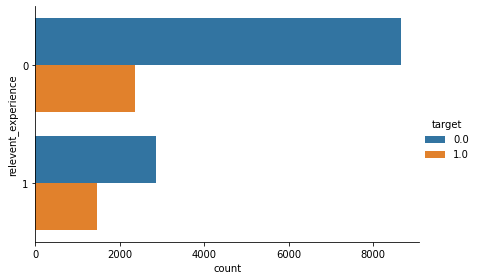

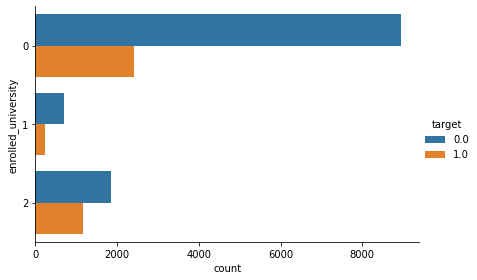

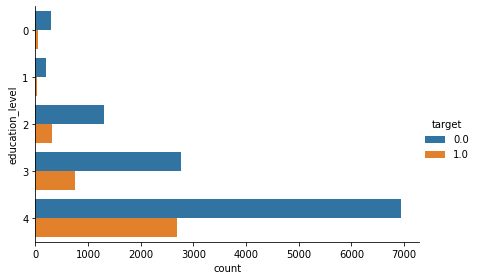

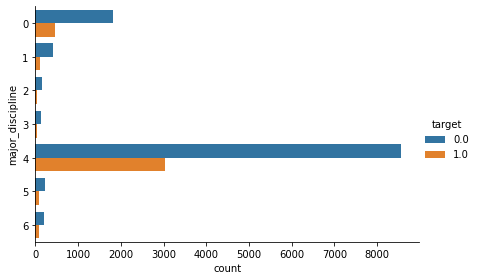

In [30]:
X_train_ = X_train.copy()
X_train_['target'] = y_train
for var in cat_vars_ordinal:
    sns.catplot(y=var, hue='target', data=X_train_, kind="count", height=4, aspect=1.5)
    plt.show()

In [31]:
## Feature Scaling